# Further improvements

This notebook performs pilot studies into possible routes for further improving the classification results obtained from the offline experiments.
This includes:
   - Calibration on 5 minutes worth of data
   - Subsampling electrodes

Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Calibrating on 5 minutes of training
   - EEGNet: new session
   - EEGNet: new subject
   - LSTM EEGNet
      - Results
- Subsampling electrodes
   - CSP + LDA
      - Results
   - EEGNet
      - Results
   - LSTM EEGNet
      - Results

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# EEGNet model with LSTM
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Calibrating on 5 minutes of training

In the data collection setup the marker stayed on the screen for one singular second and was followed by a 1.5 – 2.5 second pause after which the next signal was shown.
This totals 3.5 seconds per sample taken.
As such, in 5 minutes, or 300 seconds, 85 samples should be obtainable.
This is reduced to 75 samples in order to obtain 25 samples per class.
These 25 samples per class are then used for calibration of both the EEGNet model and the EEGNet model extension with LSTM provided by us to compare both.
Different layers are frozen to test different setups.

<hr>

### EEGNet: new session

Results for EEGNet base were:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

Result after calibration are:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6667 @ epoch 459                   | 0.8669 @ epoch 1846              | 0.6429                                           | 0.6181                                            |
| C           | 0.8 @ epoch 39                       | 0.798 @ epoch 2486               | 0.7104                                           | 0.7387                                            |
| E           | 0.7667 @ epoch 56                    | 0.597 @ epoch 2500               | 0.7568                                           | 0.758                                             |

In [ ]:
EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
).layers

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsession_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet: new subject

Results for EEGNet base were:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

Result after calibration are:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.6 @ epoch 193                      | 0.8591 @ epoch 194               | 0.6373                                           | 0.6373                                            |
| C (Train B&E) | 0.7667 @ epoch 304                   | 0.6773 @ epoch 2486              | 0.6233                                           | 0.6188                                            |
| E (Train B&C) | 0.7333 @ epoch 85                    | 0.6853 @ epoch 2374              | 0.6432                                           | 0.6602                                            |

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/newsubject/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsubject_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet with LSTM conv: new session

Results before calibration were:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Result after calibration are:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7333 @ epoch 213                             | 0.8291 @ epoch 82                          | 0.6158                                                     | 0.6395                                                      |
| C           | 0.8 @ epoch 1                                  | 0.6055 @ epoch 185                         | 0.6595                                                     | 0.6652                                                      |
| E           | 0.8 @ epoch 11                                 | 0.6687 @ epoch 457                         | 0.6727                                                     | 0.7807                                                      |

In [6]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).layers

In [7]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = True

keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_convlstm_calibration_newsession_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                
                # Allow last layers to train (softmax)
                calibration_model.layers[11].trainable = True
                calibration_model.layers[12].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                
                
                # Change dropout
                calibration_model.layers[6].rate = 0
                calibration_model.layers[9].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model



####################################################
# RESULTS FOR SUBJECT B
####################################################

Calibrating with (45, 21, 100) windows
Testing with (885, 21, 100) windows
Calibrating epochs


Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,885
Events,task/left: 297task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.5556
Epoch 1: val_loss improved from inf to 0.85899, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectB\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.9022 - accuracy: 0.5556 - val_loss: 0.8590 - val_accuracy: 0.6667
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.9403 - accuracy: 0.5778
Epoch 2: val_loss improved from 0.85899 to 0.85722, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.9403 - 

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,884
Events,task/left: 296task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.7556
Epoch 1: val_loss improved from inf to 0.82747, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.8205 - accuracy: 0.7556 - val_loss: 0.8275 - val_accuracy: 0.8000
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.7111
Epoch 2: val_loss improved from 0.82747 to 0.82429, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.80000
1/1 [==============================] - 4s 4s/step - loss: 0.8181 - 

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,880
Events,task/left: 297task/neutral: 295task/right: 288
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.6889
Epoch 1: val_loss improved from inf to 0.84041, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectE\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.6046 - accuracy: 0.6889 - val_loss: 0.8404 - val_accuracy: 0.7000
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7556
Epoch 2: val_loss improved from 0.84041 to 0.83386, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6223 - 


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9333 @ epoch 303
Best training loss (min) 0.5448 @ epoch 297

Best validation accuracy (max) 0.7333 @ epoch 213
Best validation loss (min) 0.8291 @ epoch 82

#### results for highest accuracy model ####
Accuracy of: 0.6158


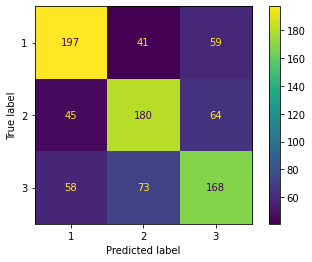


#### results for lowest loss model ####
Accuracy of: 0.6395


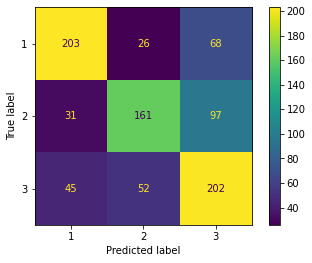


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.8889 @ epoch 405
Best training loss (min) 0.4059 @ epoch 318

Best validation accuracy (max) 0.8 @ epoch 1
Best validation loss (min) 0.6055 @ epoch 185

#### results for highest accuracy model ####
Accuracy of: 0.6595


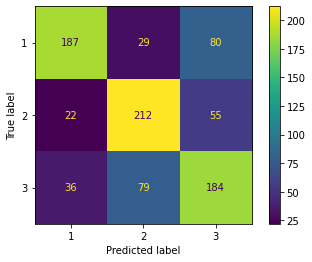


#### results for lowest loss model ####
Accuracy of: 0.6652


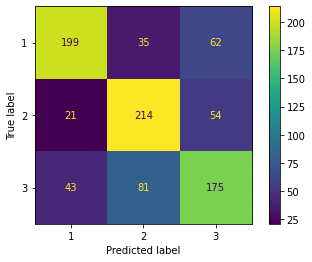


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9333 @ epoch 205
Best training loss (min) 0.3736 @ epoch 486

Best validation accuracy (max) 0.8 @ epoch 11
Best validation loss (min) 0.6687 @ epoch 457

#### results for highest accuracy model ####
Accuracy of: 0.6727


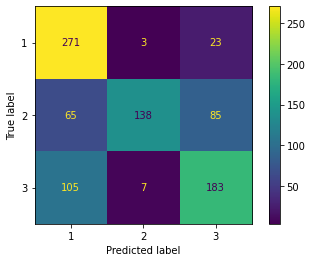


#### results for lowest loss model ####
Accuracy of: 0.7807


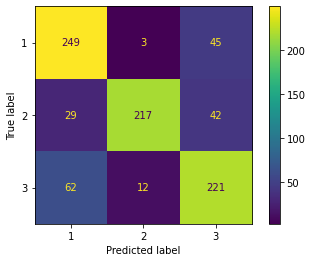

In [9]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet with LSTM conv: new subject

Results before calibration were:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7497 @ epoch 82                              | 0.6353 @ epoch 47                          | 0.626                                                      | 0.6125                                                      |
| C           | 0.7329 @ epoch 50                              | 0.6575 @ epoch 109                         | 0.6204                                                     | 0.5746                                                      |
| E           | 0.724 @ epoch 240                              | 0.6687 @ epoch 75                          | 0.6136                                                     | 0.6618                                                      |

Result after calibration are:

| **Subject**   | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|---------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B (Train C&E) | 0.6667 @ epoch 182                             | 0.8062 @ epoch 366                         | 0.6249                                                     | 0.626                                                       |
| C (Train B&E) | 0.7333 @ epoch 206                             | 0.7253 @ epoch 240                         | 0.621                                                      | 0.6199                                                      |
| E (Train B&C) | 0.8667 @ epoch 9                               | 0.3985 @ epoch 378                         | 0.6625                                                     | 0.7216                                                      |

In [14]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = True

keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_convlstm_calibration_newsubject_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                
                # Allow last layers to train (softmax)
                calibration_model.layers[11].trainable = True
                calibration_model.layers[12].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                
                
                # Change dropout
                calibration_model.layers[6].rate = 0
                calibration_model.layers[9].rate = 0.3
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.00005), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model



####################################################
# RESULTS FOR SUBJECT B
####################################################

Calibrating with (45, 21, 100) windows
Testing with (885, 21, 100) windows
Calibrating epochs


Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,885
Events,task/left: 297task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 0.9363 - accuracy: 0.5778
Epoch 1: val_loss improved from inf to 0.89887, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.9363 - accuracy: 0.5778 - val_loss: 0.8989 - val_accuracy: 0.6000
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 0.8544 - accuracy: 0.6444
Epoch 2: val_loss improved from 0.89887 to 0.89791, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.60000
1/1 [==============================] - 4s 4s/step - loss: 0.8544 - accuracy: 0.6444 - val_loss: 0.8979 - val_accuracy

Epoch 21/500
1/1 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.6667
Epoch 21: val_loss did not improve from 0.89307

Epoch 21: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8645 - accuracy: 0.6667 - val_loss: 0.8934 - val_accuracy: 0.6333
Epoch 22/500
1/1 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.5778
Epoch 22: val_loss did not improve from 0.89307

Epoch 22: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8790 - accuracy: 0.5778 - val_loss: 0.8933 - val_accuracy: 0.6333
Epoch 23/500
1/1 [==============================] - ETA: 0s - loss: 0.8738 - accuracy: 0.5778
Epoch 23: val_loss did not improve from 0.89307

Epoch 23: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8738 - accuracy: 0.5778 - val_loss: 0.8932 - val_accuracy: 0.6333
Epoch 24/500
1/1 [===================

1/1 [==============================] - ETA: 0s - loss: 0.8456 - accuracy: 0.6000
Epoch 40: val_loss improved from 0.88638 to 0.88583, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 40: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8456 - accuracy: 0.6000 - val_loss: 0.8858 - val_accuracy: 0.6333
Epoch 41/500
1/1 [==============================] - ETA: 0s - loss: 0.8368 - accuracy: 0.6667
Epoch 41: val_loss improved from 0.88583 to 0.88529, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 41: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8368 - accuracy: 0.6667 - val_loss: 0.8853 - val_accuracy: 0.6333
Epoch 42/500
1/1 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.6667
Epoch 42: val_loss improv


Epoch 58: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8182 - accuracy: 0.6222 - val_loss: 0.8779 - val_accuracy: 0.6333
Epoch 59/500
1/1 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.6444
Epoch 59: val_loss improved from 0.87793 to 0.87750, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 59: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7952 - accuracy: 0.6444 - val_loss: 0.8775 - val_accuracy: 0.6333
Epoch 60/500
1/1 [==============================] - ETA: 0s - loss: 0.8889 - accuracy: 0.5778
Epoch 60: val_loss improved from 0.87750 to 0.87707, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 60: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - l

Epoch 77/500
1/1 [==============================] - ETA: 0s - loss: 0.8053 - accuracy: 0.6889
Epoch 77: val_loss improved from 0.87000 to 0.86955, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 77: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8053 - accuracy: 0.6889 - val_loss: 0.8695 - val_accuracy: 0.6333
Epoch 78/500
1/1 [==============================] - ETA: 0s - loss: 0.8531 - accuracy: 0.6000
Epoch 78: val_loss improved from 0.86955 to 0.86908, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 78: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8531 - accuracy: 0.6000 - val_loss: 0.8691 - val_accuracy: 0.6333
Epoch 79/500
1/1 [==============================] - ETA: 0s - loss: 0.7815 - accuracy: 0.6444
Epoch 79: va


Epoch 95: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7640 - accuracy: 0.6889 - val_loss: 0.8615 - val_accuracy: 0.6333
Epoch 96/500
1/1 [==============================] - ETA: 0s - loss: 0.7917 - accuracy: 0.6667
Epoch 96: val_loss improved from 0.86149 to 0.86104, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 96: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7917 - accuracy: 0.6667 - val_loss: 0.8610 - val_accuracy: 0.6333
Epoch 97/500
1/1 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.6444
Epoch 97: val_loss improved from 0.86104 to 0.86060, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 97: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - l

Epoch 114/500
1/1 [==============================] - ETA: 0s - loss: 0.7892 - accuracy: 0.6444
Epoch 114: val_loss improved from 0.85314 to 0.85269, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 114: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7892 - accuracy: 0.6444 - val_loss: 0.8527 - val_accuracy: 0.6333
Epoch 115/500
1/1 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.7111
Epoch 115: val_loss improved from 0.85269 to 0.85224, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 115: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7394 - accuracy: 0.7111 - val_loss: 0.8522 - val_accuracy: 0.6333
Epoch 116/500
1/1 [==============================] - ETA: 0s - loss: 0.7768 - accuracy: 0.6667
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.7925 - accuracy: 0.6667
Epoch 132: val_loss improved from 0.84346 to 0.84275, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 132: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7925 - accuracy: 0.6667 - val_loss: 0.8428 - val_accuracy: 0.6333
Epoch 133/500
1/1 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7333
Epoch 133: val_loss improved from 0.84275 to 0.84207, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 133: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7310 - accuracy: 0.7333 - val_loss: 0.8421 - val_accuracy: 0.6333
Epoch 134/500
1/1 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.7111
Epoch 134: val_loss


Epoch 150: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7218 - accuracy: 0.7333 - val_loss: 0.8329 - val_accuracy: 0.6333
Epoch 151/500
1/1 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.7111
Epoch 151: val_loss improved from 0.83288 to 0.83241, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 151: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7427 - accuracy: 0.7111 - val_loss: 0.8324 - val_accuracy: 0.6333
Epoch 152/500
1/1 [==============================] - ETA: 0s - loss: 0.7198 - accuracy: 0.7111
Epoch 152: val_loss improved from 0.83241 to 0.83192, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 152: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/s

Epoch 169/500
1/1 [==============================] - ETA: 0s - loss: 0.7295 - accuracy: 0.6667
Epoch 169: val_loss improved from 0.82473 to 0.82434, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 169: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7295 - accuracy: 0.6667 - val_loss: 0.8243 - val_accuracy: 0.6333
Epoch 170/500
1/1 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.7333
Epoch 170: val_loss improved from 0.82434 to 0.82395, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 170: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7154 - accuracy: 0.7333 - val_loss: 0.8240 - val_accuracy: 0.6333
Epoch 171/500
1/1 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.7111
Epoch

Epoch 187/500
1/1 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7333
Epoch 187: val_loss improved from 0.81948 to 0.81929, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 187: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.7010 - accuracy: 0.7333 - val_loss: 0.8193 - val_accuracy: 0.6667
Epoch 188/500
1/1 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.7778
Epoch 188: val_loss improved from 0.81929 to 0.81913, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 188: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.7058 - accuracy: 0.7778 - val_loss: 0.8191 - val_accuracy: 0.6667
Epoch 189/500
1/1 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.8000
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.7556
Epoch 205: val_loss improved from 0.81703 to 0.81689, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 205: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6990 - accuracy: 0.7556 - val_loss: 0.8169 - val_accuracy: 0.6667
Epoch 206/500
1/1 [==============================] - ETA: 0s - loss: 0.7068 - accuracy: 0.7111
Epoch 206: val_loss improved from 0.81689 to 0.81678, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 206: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.7068 - accuracy: 0.7111 - val_loss: 0.8168 - val_accuracy: 0.6667
Epoch 207/500
1/1 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.7778
Epoch 207: val_loss


Epoch 223: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6900 - accuracy: 0.8222 - val_loss: 0.8153 - val_accuracy: 0.6667
Epoch 224/500
1/1 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.7778
Epoch 224: val_loss improved from 0.81532 to 0.81526, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 224: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6827 - accuracy: 0.7778 - val_loss: 0.8153 - val_accuracy: 0.6667
Epoch 225/500
1/1 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.7778
Epoch 225: val_loss improved from 0.81526 to 0.81520, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 225: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/s

Epoch 242/500
1/1 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.7333
Epoch 242: val_loss improved from 0.81365 to 0.81353, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 242: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6982 - accuracy: 0.7333 - val_loss: 0.8135 - val_accuracy: 0.6667
Epoch 243/500
1/1 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.7778
Epoch 243: val_loss improved from 0.81353 to 0.81343, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 243: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6678 - accuracy: 0.7778 - val_loss: 0.8134 - val_accuracy: 0.6667
Epoch 244/500
1/1 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.7333
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.8667
Epoch 260: val_loss improved from 0.81211 to 0.81208, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 260: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6572 - accuracy: 0.8667 - val_loss: 0.8121 - val_accuracy: 0.6667
Epoch 261/500
1/1 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.8000
Epoch 261: val_loss improved from 0.81208 to 0.81202, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 261: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6519 - accuracy: 0.8000 - val_loss: 0.8120 - val_accuracy: 0.6667
Epoch 262/500
1/1 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7333
Epoch 262: val_loss


Epoch 278: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6692 - accuracy: 0.8000 - val_loss: 0.8110 - val_accuracy: 0.6667
Epoch 279/500
1/1 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.7333
Epoch 279: val_loss improved from 0.81095 to 0.81093, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 279: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.7119 - accuracy: 0.7333 - val_loss: 0.8109 - val_accuracy: 0.6667
Epoch 280/500
1/1 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.8000
Epoch 280: val_loss improved from 0.81093 to 0.81091, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 280: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/s

Epoch 297/500
1/1 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.8000
Epoch 297: val_loss improved from 0.80980 to 0.80972, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 297: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6395 - accuracy: 0.8000 - val_loss: 0.8097 - val_accuracy: 0.6667
Epoch 298/500
1/1 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.8667
Epoch 298: val_loss improved from 0.80972 to 0.80964, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 298: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6195 - accuracy: 0.8667 - val_loss: 0.8096 - val_accuracy: 0.6667
Epoch 299/500
1/1 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.8000
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.8444
Epoch 315: val_loss improved from 0.80855 to 0.80852, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 315: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6571 - accuracy: 0.8444 - val_loss: 0.8085 - val_accuracy: 0.6667
Epoch 316/500
1/1 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.8444
Epoch 316: val_loss improved from 0.80852 to 0.80850, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 316: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6253 - accuracy: 0.8444 - val_loss: 0.8085 - val_accuracy: 0.6667
Epoch 317/500
1/1 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.8222
Epoch 317: val_loss


Epoch 333: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6175 - accuracy: 0.8000 - val_loss: 0.8077 - val_accuracy: 0.6667
Epoch 334/500
1/1 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.7556
Epoch 334: val_loss improved from 0.80774 to 0.80764, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 334: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6781 - accuracy: 0.7556 - val_loss: 0.8076 - val_accuracy: 0.6667
Epoch 335/500
1/1 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7333
Epoch 335: val_loss improved from 0.80764 to 0.80755, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 335: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/s

Epoch 352/500
1/1 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.8000
Epoch 352: val_loss improved from 0.80664 to 0.80660, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 352: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6049 - accuracy: 0.8000 - val_loss: 0.8066 - val_accuracy: 0.6667
Epoch 353/500
1/1 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.8667
Epoch 353: val_loss improved from 0.80660 to 0.80655, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 353: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6297 - accuracy: 0.8667 - val_loss: 0.8065 - val_accuracy: 0.6667
Epoch 354/500
1/1 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.8000
Epoch

1/1 [==============================] - 4s 4s/step - loss: 0.6716 - accuracy: 0.7556 - val_loss: 0.8062 - val_accuracy: 0.6667
Epoch 372/500
1/1 [==============================] - ETA: 0s - loss: 0.6280 - accuracy: 0.8667
Epoch 372: val_loss did not improve from 0.80618

Epoch 372: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6280 - accuracy: 0.8667 - val_loss: 0.8062 - val_accuracy: 0.6667
Epoch 373/500
1/1 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.8667
Epoch 373: val_loss did not improve from 0.80618

Epoch 373: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6276 - accuracy: 0.8667 - val_loss: 0.8062 - val_accuracy: 0.6667
Epoch 374/500
1/1 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.8667
Epoch 374: val_loss did not improve from 0.80618

Epoch 374: val_accuracy did not improve from 0.66667
1/1 [=======================

Epoch 397/500
1/1 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.8444
Epoch 397: val_loss did not improve from 0.80618

Epoch 397: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6417 - accuracy: 0.8444 - val_loss: 0.8068 - val_accuracy: 0.6667
Epoch 398/500
1/1 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.8667
Epoch 398: val_loss did not improve from 0.80618

Epoch 398: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6260 - accuracy: 0.8667 - val_loss: 0.8068 - val_accuracy: 0.6333
Epoch 399/500
1/1 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.8667
Epoch 399: val_loss did not improve from 0.80618

Epoch 399: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6178 - accuracy: 0.8667 - val_loss: 0.8069 - val_accuracy: 0.6333
Epoch 400/500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.8889
Epoch 422: val_loss did not improve from 0.80618

Epoch 422: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6026 - accuracy: 0.8889 - val_loss: 0.8067 - val_accuracy: 0.6333
Epoch 423/500
1/1 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.8444
Epoch 423: val_loss did not improve from 0.80618

Epoch 423: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6300 - accuracy: 0.8444 - val_loss: 0.8067 - val_accuracy: 0.6333
Epoch 424/500
1/1 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.7778
Epoch 424: val_loss did not improve from 0.80618

Epoch 424: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6581 - accuracy: 0.7778 - val_loss: 0.8067 - val_accuracy: 0.6333
Epoch 425/500
1/1 [=======================


Epoch 447: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6283 - accuracy: 0.8444 - val_loss: 0.8066 - val_accuracy: 0.6333
Epoch 448/500
1/1 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.8444
Epoch 448: val_loss did not improve from 0.80618

Epoch 448: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6061 - accuracy: 0.8444 - val_loss: 0.8066 - val_accuracy: 0.6333
Epoch 449/500
1/1 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.8444
Epoch 449: val_loss did not improve from 0.80618

Epoch 449: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6303 - accuracy: 0.8444 - val_loss: 0.8066 - val_accuracy: 0.6333
Epoch 450/500
1/1 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.8444
Epoch 450: val_loss did not improve from 0.80618

Epoch 450: val_accuracy did

Epoch 473/500
1/1 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.8667
Epoch 473: val_loss did not improve from 0.80618

Epoch 473: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6100 - accuracy: 0.8667 - val_loss: 0.8072 - val_accuracy: 0.6000
Epoch 474/500
1/1 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.8667
Epoch 474: val_loss did not improve from 0.80618

Epoch 474: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6046 - accuracy: 0.8667 - val_loss: 0.8073 - val_accuracy: 0.6000
Epoch 475/500
1/1 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.8000
Epoch 475: val_loss did not improve from 0.80618

Epoch 475: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6561 - accuracy: 0.8000 - val_loss: 0.8073 - val_accuracy: 0.6000
Epoch 476/500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.8667
Epoch 498: val_loss did not improve from 0.80618

Epoch 498: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6374 - accuracy: 0.8667 - val_loss: 0.8081 - val_accuracy: 0.6000
Epoch 499/500
1/1 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.8667
Epoch 499: val_loss did not improve from 0.80618

Epoch 499: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.5990 - accuracy: 0.8667 - val_loss: 0.8081 - val_accuracy: 0.6000
Epoch 500/500
1/1 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.8444
Epoch 500: val_loss did not improve from 0.80618

Epoch 500: val_accuracy did not improve from 0.66667
1/1 [==============================] - 4s 4s/step - loss: 0.6016 - accuracy: 0.8444 - val_loss: 0.8082 - val_accuracy: 0.6000

#########################################

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,884
Events,task/left: 296task/neutral: 299task/right: 289
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 0.8753 - accuracy: 0.6000
Epoch 1: val_loss improved from inf to 0.84036, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.63333, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.8753 - accuracy: 0.6000 - val_loss: 0.8404 - val_accuracy: 0.6333
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.5556
Epoch 2: val_loss improved from 0.84036 to 0.83814, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8790 - accuracy: 0.5556 - val_loss: 0.8381 - val_accuracy

1/1 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.6222
Epoch 19: val_loss improved from 0.81587 to 0.81499, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8311 - accuracy: 0.6222 - val_loss: 0.8150 - val_accuracy: 0.6333
Epoch 20/500
1/1 [==============================] - ETA: 0s - loss: 0.8540 - accuracy: 0.5778
Epoch 20: val_loss improved from 0.81499 to 0.81414, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.8540 - accuracy: 0.5778 - val_loss: 0.8141 - val_accuracy: 0.6333
Epoch 21/500
1/1 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.6222
Epoch 21: val_loss improv


Epoch 37: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7685 - accuracy: 0.5778 - val_loss: 0.8027 - val_accuracy: 0.6333
Epoch 38/500
1/1 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.6222
Epoch 38: val_loss improved from 0.80269 to 0.80218, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 38: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7942 - accuracy: 0.6222 - val_loss: 0.8022 - val_accuracy: 0.6333
Epoch 39/500
1/1 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.6667
Epoch 39: val_loss improved from 0.80218 to 0.80169, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 39: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - l

Epoch 56/500
1/1 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.6667
Epoch 56: val_loss improved from 0.79390 to 0.79337, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 56: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7873 - accuracy: 0.6667 - val_loss: 0.7934 - val_accuracy: 0.6333
Epoch 57/500
1/1 [==============================] - ETA: 0s - loss: 0.7772 - accuracy: 0.6889
Epoch 57: val_loss improved from 0.79337 to 0.79284, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 57: val_accuracy did not improve from 0.63333
1/1 [==============================] - 4s 4s/step - loss: 0.7772 - accuracy: 0.6889 - val_loss: 0.7928 - val_accuracy: 0.6333
Epoch 58/500
1/1 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.6667
Epoch 58: va

Epoch 74/500
1/1 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.6667
Epoch 74: val_loss improved from 0.78287 to 0.78220, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 74: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.7516 - accuracy: 0.6667 - val_loss: 0.7822 - val_accuracy: 0.7000
Epoch 75/500
1/1 [==============================] - ETA: 0s - loss: 0.7568 - accuracy: 0.6889
Epoch 75: val_loss improved from 0.78220 to 0.78154, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 75: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.7568 - accuracy: 0.6889 - val_loss: 0.7815 - val_accuracy: 0.7000
Epoch 76/500
1/1 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.6222
Epoch 76: va


Epoch 92: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.7774 - accuracy: 0.6000 - val_loss: 0.7718 - val_accuracy: 0.7000
Epoch 93/500
1/1 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.7111
Epoch 93: val_loss improved from 0.77178 to 0.77128, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 93: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.7544 - accuracy: 0.7111 - val_loss: 0.7713 - val_accuracy: 0.7000
Epoch 94/500
1/1 [==============================] - ETA: 0s - loss: 0.7254 - accuracy: 0.6667
Epoch 94: val_loss improved from 0.77128 to 0.77079, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 94: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - l

Epoch 111/500
1/1 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.6889
Epoch 111: val_loss improved from 0.76340 to 0.76298, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 111: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6942 - accuracy: 0.6889 - val_loss: 0.7630 - val_accuracy: 0.6667
Epoch 112/500
1/1 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.6667
Epoch 112: val_loss improved from 0.76298 to 0.76256, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 112: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6747 - accuracy: 0.6667 - val_loss: 0.7626 - val_accuracy: 0.6667
Epoch 113/500
1/1 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.7333
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7111
Epoch 129: val_loss improved from 0.75545 to 0.75498, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 129: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6794 - accuracy: 0.7111 - val_loss: 0.7550 - val_accuracy: 0.7000
Epoch 130/500
1/1 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.6667
Epoch 130: val_loss improved from 0.75498 to 0.75453, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 130: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.7282 - accuracy: 0.6667 - val_loss: 0.7545 - val_accuracy: 0.7000
Epoch 131/500
1/1 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7111
Epoch 131: val_loss


Epoch 147: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6707 - accuracy: 0.7556 - val_loss: 0.7482 - val_accuracy: 0.7000
Epoch 148/500
1/1 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.7111
Epoch 148: val_loss improved from 0.74823 to 0.74795, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 148: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6900 - accuracy: 0.7111 - val_loss: 0.7480 - val_accuracy: 0.7000
Epoch 149/500
1/1 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.7556
Epoch 149: val_loss improved from 0.74795 to 0.74768, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 149: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/s

Epoch 166/500
1/1 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.6889
Epoch 166: val_loss improved from 0.74256 to 0.74217, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 166: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6824 - accuracy: 0.6889 - val_loss: 0.7422 - val_accuracy: 0.7000
Epoch 167/500
1/1 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.6889
Epoch 167: val_loss improved from 0.74217 to 0.74179, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 167: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.7066 - accuracy: 0.6889 - val_loss: 0.7418 - val_accuracy: 0.7000
Epoch 168/500
1/1 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7111
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.7778
Epoch 184: val_loss improved from 0.73612 to 0.73579, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 184: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6248 - accuracy: 0.7778 - val_loss: 0.7358 - val_accuracy: 0.7000
Epoch 185/500
1/1 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7111
Epoch 185: val_loss improved from 0.73579 to 0.73546, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 185: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6703 - accuracy: 0.7111 - val_loss: 0.7355 - val_accuracy: 0.7000
Epoch 186/500
1/1 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.7111
Epoch 186: val_loss


Epoch 202: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6460 - accuracy: 0.7111 - val_loss: 0.7310 - val_accuracy: 0.7000
Epoch 203/500
1/1 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.7111
Epoch 203: val_loss improved from 0.73098 to 0.73073, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 203: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/step - loss: 0.6781 - accuracy: 0.7111 - val_loss: 0.7307 - val_accuracy: 0.7000
Epoch 204/500
1/1 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.7556
Epoch 204: val_loss improved from 0.73073 to 0.73047, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 204: val_accuracy did not improve from 0.70000
1/1 [==============================] - 4s 4s/s


Epoch 220: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6485 - accuracy: 0.7556 - val_loss: 0.7270 - val_accuracy: 0.7333
Epoch 221/500
1/1 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.7111
Epoch 221: val_loss improved from 0.72703 to 0.72688, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 221: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6245 - accuracy: 0.7111 - val_loss: 0.7269 - val_accuracy: 0.7333
Epoch 222/500
1/1 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.7333
Epoch 222: val_loss improved from 0.72688 to 0.72674, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 222: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/s

Epoch 239/500
1/1 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.7111
Epoch 239: val_loss improved from 0.72536 to 0.72535, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 239: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6573 - accuracy: 0.7111 - val_loss: 0.7253 - val_accuracy: 0.7000
Epoch 240/500
1/1 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.7333
Epoch 240: val_loss improved from 0.72535 to 0.72534, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 240: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6342 - accuracy: 0.7333 - val_loss: 0.7253 - val_accuracy: 0.7000
Epoch 241/500
1/1 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6889
Epoch

1/1 [==============================] - 4s 4s/step - loss: 0.6024 - accuracy: 0.7111 - val_loss: 0.7274 - val_accuracy: 0.7000
Epoch 264/500
1/1 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.7111
Epoch 264: val_loss did not improve from 0.72534

Epoch 264: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6370 - accuracy: 0.7111 - val_loss: 0.7275 - val_accuracy: 0.7000
Epoch 265/500
1/1 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.7111
Epoch 265: val_loss did not improve from 0.72534

Epoch 265: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6350 - accuracy: 0.7111 - val_loss: 0.7276 - val_accuracy: 0.7000
Epoch 266/500
1/1 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7556
Epoch 266: val_loss did not improve from 0.72534

Epoch 266: val_accuracy did not improve from 0.73333
1/1 [=======================

Epoch 289/500
1/1 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.6889
Epoch 289: val_loss did not improve from 0.72534

Epoch 289: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6586 - accuracy: 0.6889 - val_loss: 0.7313 - val_accuracy: 0.7000
Epoch 290/500
1/1 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.7556
Epoch 290: val_loss did not improve from 0.72534

Epoch 290: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5923 - accuracy: 0.7556 - val_loss: 0.7315 - val_accuracy: 0.7000
Epoch 291/500
1/1 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.7556
Epoch 291: val_loss did not improve from 0.72534

Epoch 291: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5967 - accuracy: 0.7556 - val_loss: 0.7317 - val_accuracy: 0.7000
Epoch 292/500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.7778
Epoch 314: val_loss did not improve from 0.72534

Epoch 314: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5943 - accuracy: 0.7778 - val_loss: 0.7370 - val_accuracy: 0.7000
Epoch 315/500
1/1 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.7556
Epoch 315: val_loss did not improve from 0.72534

Epoch 315: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5988 - accuracy: 0.7556 - val_loss: 0.7372 - val_accuracy: 0.7000
Epoch 316/500
1/1 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.7333
Epoch 316: val_loss did not improve from 0.72534

Epoch 316: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6120 - accuracy: 0.7333 - val_loss: 0.7374 - val_accuracy: 0.7000
Epoch 317/500
1/1 [=======================


Epoch 339: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6398 - accuracy: 0.7333 - val_loss: 0.7415 - val_accuracy: 0.7000
Epoch 340/500
1/1 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.7556
Epoch 340: val_loss did not improve from 0.72534

Epoch 340: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5912 - accuracy: 0.7556 - val_loss: 0.7416 - val_accuracy: 0.7000
Epoch 341/500
1/1 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7778
Epoch 341: val_loss did not improve from 0.72534

Epoch 341: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5977 - accuracy: 0.7778 - val_loss: 0.7418 - val_accuracy: 0.7000
Epoch 342/500
1/1 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.7333
Epoch 342: val_loss did not improve from 0.72534

Epoch 342: val_accuracy did

Epoch 365/500
1/1 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.7778
Epoch 365: val_loss did not improve from 0.72534

Epoch 365: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5592 - accuracy: 0.7778 - val_loss: 0.7452 - val_accuracy: 0.7333
Epoch 366/500
1/1 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.7111
Epoch 366: val_loss did not improve from 0.72534

Epoch 366: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6221 - accuracy: 0.7111 - val_loss: 0.7453 - val_accuracy: 0.7333
Epoch 367/500
1/1 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.7111
Epoch 367: val_loss did not improve from 0.72534

Epoch 367: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6116 - accuracy: 0.7111 - val_loss: 0.7454 - val_accuracy: 0.7333
Epoch 368/500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.7778
Epoch 390: val_loss did not improve from 0.72534

Epoch 390: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6062 - accuracy: 0.7778 - val_loss: 0.7492 - val_accuracy: 0.7333
Epoch 391/500
1/1 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.7556
Epoch 391: val_loss did not improve from 0.72534

Epoch 391: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6001 - accuracy: 0.7556 - val_loss: 0.7494 - val_accuracy: 0.7333
Epoch 392/500
1/1 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.7333
Epoch 392: val_loss did not improve from 0.72534

Epoch 392: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6064 - accuracy: 0.7333 - val_loss: 0.7496 - val_accuracy: 0.7333
Epoch 393/500
1/1 [=======================


Epoch 415: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6012 - accuracy: 0.7556 - val_loss: 0.7530 - val_accuracy: 0.7333
Epoch 416/500
1/1 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.8000
Epoch 416: val_loss did not improve from 0.72534

Epoch 416: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5705 - accuracy: 0.8000 - val_loss: 0.7531 - val_accuracy: 0.7333
Epoch 417/500
1/1 [==============================] - ETA: 0s - loss: 0.5807 - accuracy: 0.7778
Epoch 417: val_loss did not improve from 0.72534

Epoch 417: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5807 - accuracy: 0.7778 - val_loss: 0.7533 - val_accuracy: 0.7333
Epoch 418/500
1/1 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.7778
Epoch 418: val_loss did not improve from 0.72534

Epoch 418: val_accuracy did

Epoch 441/500
1/1 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.7778
Epoch 441: val_loss did not improve from 0.72534

Epoch 441: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6030 - accuracy: 0.7778 - val_loss: 0.7563 - val_accuracy: 0.7333
Epoch 442/500
1/1 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.8000
Epoch 442: val_loss did not improve from 0.72534

Epoch 442: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5988 - accuracy: 0.8000 - val_loss: 0.7564 - val_accuracy: 0.7333
Epoch 443/500
1/1 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.7333
Epoch 443: val_loss did not improve from 0.72534

Epoch 443: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6176 - accuracy: 0.7333 - val_loss: 0.7565 - val_accuracy: 0.7333
Epoch 444/500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.7333
Epoch 466: val_loss did not improve from 0.72534

Epoch 466: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6088 - accuracy: 0.7333 - val_loss: 0.7587 - val_accuracy: 0.7333
Epoch 467/500
1/1 [==============================] - ETA: 0s - loss: 0.5750 - accuracy: 0.7778
Epoch 467: val_loss did not improve from 0.72534

Epoch 467: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5750 - accuracy: 0.7778 - val_loss: 0.7587 - val_accuracy: 0.7333
Epoch 468/500
1/1 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7333
Epoch 468: val_loss did not improve from 0.72534

Epoch 468: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5703 - accuracy: 0.7333 - val_loss: 0.7588 - val_accuracy: 0.7333
Epoch 469/500
1/1 [=======================


Epoch 491: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5622 - accuracy: 0.7556 - val_loss: 0.7593 - val_accuracy: 0.7333
Epoch 492/500
1/1 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.7333
Epoch 492: val_loss did not improve from 0.72534

Epoch 492: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.6101 - accuracy: 0.7333 - val_loss: 0.7593 - val_accuracy: 0.7333
Epoch 493/500
1/1 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7778
Epoch 493: val_loss did not improve from 0.72534

Epoch 493: val_accuracy did not improve from 0.73333
1/1 [==============================] - 4s 4s/step - loss: 0.5605 - accuracy: 0.7778 - val_loss: 0.7593 - val_accuracy: 0.7333
Epoch 494/500
1/1 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.8222
Epoch 494: val_loss did not improve from 0.72534

Epoch 494: val_accuracy did

Number of events,75
Events,task/left: 25task/neutral: 25task/right: 25
Time range,-1.000 – 2.000 sec
Baseline,off


test epochs


Number of events,880
Events,task/left: 297task/neutral: 295task/right: 288
Time range,-1.000 – 2.000 sec
Baseline,off


Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.8000
Epoch 1: val_loss improved from inf to 0.52530, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_highest_acc_model.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.6213 - accuracy: 0.8000 - val_loss: 0.5253 - val_accuracy: 0.8333
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7556
Epoch 2: val_loss improved from 0.52530 to 0.52362, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.83333
1/1 [==============================] - 4s 4s/step - loss: 0.5702 - accuracy: 0.7556 - val_loss: 0.5236 - val_accuracy

Epoch 19/500
1/1 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.7778
Epoch 19: val_loss improved from 0.50703 to 0.50602, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5717 - accuracy: 0.7778 - val_loss: 0.5060 - val_accuracy: 0.8333
Epoch 20/500
1/1 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.7556
Epoch 20: val_loss improved from 0.50602 to 0.50510, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 20: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.6269 - accuracy: 0.7556 - val_loss: 0.5051 - val_accuracy: 0.8333
Epoch 21/500
1/1 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.8000
Epoch 21: va


Epoch 40: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5791 - accuracy: 0.7556 - val_loss: 0.4963 - val_accuracy: 0.8000
Epoch 41/500
1/1 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.8222
Epoch 41: val_loss improved from 0.49632 to 0.49464, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 41: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5741 - accuracy: 0.8222 - val_loss: 0.4946 - val_accuracy: 0.8000
Epoch 42/500
1/1 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.8000
Epoch 42: val_loss improved from 0.49464 to 0.49305, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 42: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - l

Epoch 59/500
1/1 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.8000
Epoch 59: val_loss improved from 0.47406 to 0.47307, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 59: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5469 - accuracy: 0.8000 - val_loss: 0.4731 - val_accuracy: 0.8000
Epoch 60/500
1/1 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.7778
Epoch 60: val_loss improved from 0.47307 to 0.47208, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 60: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5349 - accuracy: 0.7778 - val_loss: 0.4721 - val_accuracy: 0.8000
Epoch 61/500
1/1 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.8222
Epoch 61: va


Epoch 77: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5445 - accuracy: 0.7778 - val_loss: 0.4577 - val_accuracy: 0.8000
Epoch 78/500
1/1 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.8222
Epoch 78: val_loss improved from 0.45772 to 0.45700, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 78: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5317 - accuracy: 0.8222 - val_loss: 0.4570 - val_accuracy: 0.8000
Epoch 79/500
1/1 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.8222
Epoch 79: val_loss improved from 0.45700 to 0.45629, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 79: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - l

Epoch 96/500
1/1 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.8222
Epoch 96: val_loss improved from 0.44708 to 0.44654, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 96: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5025 - accuracy: 0.8222 - val_loss: 0.4465 - val_accuracy: 0.8000
Epoch 97/500
1/1 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8444
Epoch 97: val_loss improved from 0.44654 to 0.44600, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 97: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4719 - accuracy: 0.8444 - val_loss: 0.4460 - val_accuracy: 0.8000
Epoch 98/500
1/1 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.8222
Epoch 98: va


Epoch 114: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5195 - accuracy: 0.8000 - val_loss: 0.4311 - val_accuracy: 0.8000
Epoch 115/500
1/1 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.8222
Epoch 115: val_loss improved from 0.43112 to 0.42996, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 115: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5141 - accuracy: 0.8222 - val_loss: 0.4300 - val_accuracy: 0.8000
Epoch 116/500
1/1 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.8222
Epoch 116: val_loss improved from 0.42996 to 0.42880, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 116: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/s

Epoch 133/500
1/1 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.8667
Epoch 133: val_loss improved from 0.41576 to 0.41529, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 133: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4556 - accuracy: 0.8667 - val_loss: 0.4153 - val_accuracy: 0.8000
Epoch 134/500
1/1 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8444
Epoch 134: val_loss improved from 0.41529 to 0.41483, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 134: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4773 - accuracy: 0.8444 - val_loss: 0.4148 - val_accuracy: 0.8000
Epoch 135/500
1/1 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.8444
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8667
Epoch 151: val_loss improved from 0.40993 to 0.40982, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 151: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4273 - accuracy: 0.8667 - val_loss: 0.4098 - val_accuracy: 0.8000
Epoch 152/500
1/1 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.7778
Epoch 152: val_loss improved from 0.40982 to 0.40972, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 152: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4809 - accuracy: 0.7778 - val_loss: 0.4097 - val_accuracy: 0.8000
Epoch 153/500
1/1 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.8667
Epoch 153: val_loss


Epoch 169: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.5114 - accuracy: 0.8000 - val_loss: 0.4090 - val_accuracy: 0.8000
Epoch 170/500
1/1 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8444
Epoch 170: val_loss improved from 0.40898 to 0.40893, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 170: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4497 - accuracy: 0.8444 - val_loss: 0.4089 - val_accuracy: 0.8000
Epoch 171/500
1/1 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.8444
Epoch 171: val_loss improved from 0.40893 to 0.40889, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 171: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/s

Epoch 188/500
1/1 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8444
Epoch 188: val_loss improved from 0.40807 to 0.40802, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 188: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4499 - accuracy: 0.8444 - val_loss: 0.4080 - val_accuracy: 0.8000
Epoch 189/500
1/1 [==============================] - ETA: 0s - loss: 0.4645 - accuracy: 0.8222
Epoch 189: val_loss improved from 0.40802 to 0.40796, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 189: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4645 - accuracy: 0.8222 - val_loss: 0.4080 - val_accuracy: 0.8000
Epoch 190/500
1/1 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.8222
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.8000
Epoch 206: val_loss improved from 0.40735 to 0.40733, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 206: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4759 - accuracy: 0.8000 - val_loss: 0.4073 - val_accuracy: 0.8000
Epoch 207/500
1/1 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.8222
Epoch 207: val_loss improved from 0.40733 to 0.40732, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 207: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4738 - accuracy: 0.8222 - val_loss: 0.4073 - val_accuracy: 0.8000
Epoch 208/500
1/1 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.8667
Epoch 208: val_loss

Epoch 229/500
1/1 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8444
Epoch 229: val_loss did not improve from 0.40726

Epoch 229: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4675 - accuracy: 0.8444 - val_loss: 0.4074 - val_accuracy: 0.8000
Epoch 230/500
1/1 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8444
Epoch 230: val_loss did not improve from 0.40726

Epoch 230: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4297 - accuracy: 0.8444 - val_loss: 0.4074 - val_accuracy: 0.8000
Epoch 231/500
1/1 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8000
Epoch 231: val_loss did not improve from 0.40726

Epoch 231: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4668 - accuracy: 0.8000 - val_loss: 0.4074 - val_accuracy: 0.8000
Epoch 232/500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.8667
Epoch 249: val_loss improved from 0.40676 to 0.40673, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 249: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4576 - accuracy: 0.8667 - val_loss: 0.4067 - val_accuracy: 0.8000
Epoch 250/500
1/1 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8889
Epoch 250: val_loss improved from 0.40673 to 0.40670, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 250: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4451 - accuracy: 0.8889 - val_loss: 0.4067 - val_accuracy: 0.8000
Epoch 251/500
1/1 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8667
Epoch 251: val_loss


Epoch 267: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4131 - accuracy: 0.8667 - val_loss: 0.4057 - val_accuracy: 0.8000
Epoch 268/500
1/1 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8222
Epoch 268: val_loss improved from 0.40572 to 0.40566, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 268: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4604 - accuracy: 0.8222 - val_loss: 0.4057 - val_accuracy: 0.8000
Epoch 269/500
1/1 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8667
Epoch 269: val_loss improved from 0.40566 to 0.40560, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 269: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/s

Epoch 286/500
1/1 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8444
Epoch 286: val_loss improved from 0.40438 to 0.40428, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 286: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4499 - accuracy: 0.8444 - val_loss: 0.4043 - val_accuracy: 0.8000
Epoch 287/500
1/1 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.8444
Epoch 287: val_loss improved from 0.40428 to 0.40417, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 287: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4176 - accuracy: 0.8444 - val_loss: 0.4042 - val_accuracy: 0.8000
Epoch 288/500
1/1 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8889
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.9111
Epoch 304: val_loss improved from 0.40277 to 0.40269, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 304: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4076 - accuracy: 0.9111 - val_loss: 0.4027 - val_accuracy: 0.8000
Epoch 305/500
1/1 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.8444
Epoch 305: val_loss improved from 0.40269 to 0.40262, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 305: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4344 - accuracy: 0.8444 - val_loss: 0.4026 - val_accuracy: 0.8000
Epoch 306/500
1/1 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8667
Epoch 306: val_loss


Epoch 322: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4363 - accuracy: 0.8667 - val_loss: 0.4014 - val_accuracy: 0.8000
Epoch 323/500
1/1 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8889
Epoch 323: val_loss improved from 0.40138 to 0.40129, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 323: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4072 - accuracy: 0.8889 - val_loss: 0.4013 - val_accuracy: 0.8000
Epoch 324/500
1/1 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.8222
Epoch 324: val_loss improved from 0.40129 to 0.40121, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 324: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/s

Epoch 341/500
1/1 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.9111
Epoch 341: val_loss improved from 0.40007 to 0.39999, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 341: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.3913 - accuracy: 0.9111 - val_loss: 0.4000 - val_accuracy: 0.8333
Epoch 342/500
1/1 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8667
Epoch 342: val_loss improved from 0.39999 to 0.39990, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 342: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4206 - accuracy: 0.8667 - val_loss: 0.3999 - val_accuracy: 0.8333
Epoch 343/500
1/1 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8444
Epoch

1/1 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8889
Epoch 359: val_loss improved from 0.39910 to 0.39907, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 359: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4082 - accuracy: 0.8889 - val_loss: 0.3991 - val_accuracy: 0.8667
Epoch 360/500
1/1 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8444
Epoch 360: val_loss improved from 0.39907 to 0.39905, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 360: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4001 - accuracy: 0.8444 - val_loss: 0.3990 - val_accuracy: 0.8667
Epoch 361/500
1/1 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.8667
Epoch 361: val_loss


Epoch 377: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.3870 - accuracy: 0.8444 - val_loss: 0.3985 - val_accuracy: 0.8667
Epoch 378/500
1/1 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8444
Epoch 378: val_loss improved from 0.39847 to 0.39847, saving model to saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 378: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4449 - accuracy: 0.8444 - val_loss: 0.3985 - val_accuracy: 0.8667
Epoch 379/500
1/1 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8667
Epoch 379: val_loss did not improve from 0.39847

Epoch 379: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4119 - accuracy: 0.8667 - val_loss: 0.3985 - val_accuracy: 0.8667
Epoch 380/500
1/1 [===========================


Epoch 402: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4308 - accuracy: 0.8444 - val_loss: 0.3987 - val_accuracy: 0.8667
Epoch 403/500
1/1 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8667
Epoch 403: val_loss did not improve from 0.39847

Epoch 403: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4097 - accuracy: 0.8667 - val_loss: 0.3987 - val_accuracy: 0.8667
Epoch 404/500
1/1 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8444
Epoch 404: val_loss did not improve from 0.39847

Epoch 404: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4340 - accuracy: 0.8444 - val_loss: 0.3987 - val_accuracy: 0.8667
Epoch 405/500
1/1 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.8889
Epoch 405: val_loss did not improve from 0.39847

Epoch 405: val_accuracy did

Epoch 428/500
1/1 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.8444
Epoch 428: val_loss did not improve from 0.39847

Epoch 428: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4503 - accuracy: 0.8444 - val_loss: 0.3989 - val_accuracy: 0.8667
Epoch 429/500
1/1 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.9333
Epoch 429: val_loss did not improve from 0.39847

Epoch 429: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4086 - accuracy: 0.9333 - val_loss: 0.3989 - val_accuracy: 0.8667
Epoch 430/500
1/1 [==============================] - ETA: 0s - loss: 0.4056 - accuracy: 0.8667
Epoch 430: val_loss did not improve from 0.39847

Epoch 430: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4056 - accuracy: 0.8667 - val_loss: 0.3989 - val_accuracy: 0.8667
Epoch 431/500
1/1 [=========

1/1 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.8889
Epoch 453: val_loss did not improve from 0.39847

Epoch 453: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4111 - accuracy: 0.8889 - val_loss: 0.3989 - val_accuracy: 0.8667
Epoch 454/500
1/1 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8667
Epoch 454: val_loss did not improve from 0.39847

Epoch 454: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4200 - accuracy: 0.8667 - val_loss: 0.3988 - val_accuracy: 0.8667
Epoch 455/500
1/1 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8667
Epoch 455: val_loss did not improve from 0.39847

Epoch 455: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4190 - accuracy: 0.8667 - val_loss: 0.3988 - val_accuracy: 0.8667
Epoch 456/500
1/1 [=======================


Epoch 478: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4046 - accuracy: 0.8444 - val_loss: 0.3991 - val_accuracy: 0.8667
Epoch 479/500
1/1 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8889
Epoch 479: val_loss did not improve from 0.39847

Epoch 479: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4027 - accuracy: 0.8889 - val_loss: 0.3991 - val_accuracy: 0.8667
Epoch 480/500
1/1 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.8667
Epoch 480: val_loss did not improve from 0.39847

Epoch 480: val_accuracy did not improve from 0.86667
1/1 [==============================] - 4s 4s/step - loss: 0.4377 - accuracy: 0.8667 - val_loss: 0.3991 - val_accuracy: 0.8667
Epoch 481/500
1/1 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8667
Epoch 481: val_loss did not improve from 0.39847

Epoch 481: val_accuracy did


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9111 @ epoch 443
Best training loss (min) 0.5606 @ epoch 417

Best validation accuracy (max) 0.6667 @ epoch 182
Best validation loss (min) 0.8062 @ epoch 366

#### results for highest accuracy model ####
Accuracy of: 0.6249


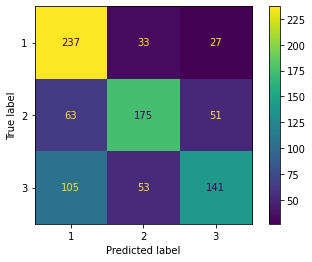


#### results for lowest loss model ####
Accuracy of: 0.626


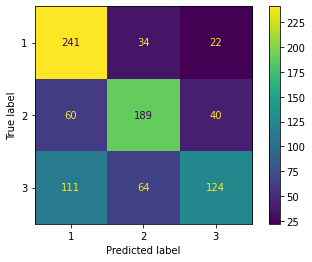


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.8444 @ epoch 338
Best training loss (min) 0.5477 @ epoch 473

Best validation accuracy (max) 0.7333 @ epoch 206
Best validation loss (min) 0.7253 @ epoch 240

#### results for highest accuracy model ####
Accuracy of: 0.621


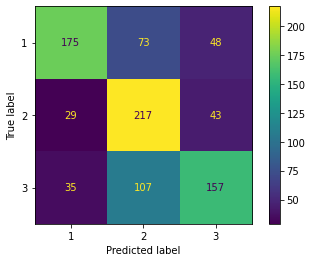


#### results for lowest loss model ####
Accuracy of: 0.6199


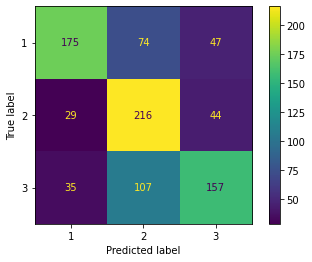


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9333 @ epoch 401
Best training loss (min) 0.3672 @ epoch 487

Best validation accuracy (max) 0.8667 @ epoch 9
Best validation loss (min) 0.3985 @ epoch 378

#### results for highest accuracy model ####
Accuracy of: 0.6625


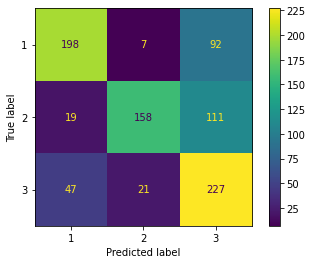


#### results for lowest loss model ####
Accuracy of: 0.7216


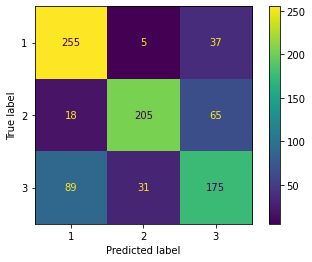

In [15]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Subsampling electrodes

According to Kaya et al., the authors of the used dataset, the channels of most interest are C3, C4, T3, T4 and Cz.

